In [1]:
import cv2 as cv
import os
from tqdm import tqdm
import random
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torchinfo import summary
import torchmetrics
from sklearn.metrics import accuracy_score
import xml.etree.ElementTree as ET

In [2]:
def displayImage(image, title=""):
    if (len(image.shape) == 3):
        cmap = None
    else:
        cmap = "gray"
    plt.rcParams['figure.figsize'] = [10, 10]
    plt.figure()
    plt.title(title)
    plt.imshow(image, cmap=cmap)
    plt.axis('off')
    plt.show()

# Dataset

In [3]:
# get train and validation datasets
images_directory = "../dataset/images"
annotations_directory = "../dataset/annotations"

with open("train.txt") as train:
    train_images_filenames = sorted(train.read().splitlines())

with open("test.txt") as test:
    val_images_filenames = sorted(test.read().splitlines())

# filter out images that can not be loaded properly
train_images_filenames = [i for i in train_images_filenames if cv.imread(
    os.path.join(images_directory, i + ".png")) is not None]
val_images_filenames = [i for i in val_images_filenames if cv.imread(
    os.path.join(images_directory, i + ".png")) is not None]

random.seed(42)
random.shuffle(train_images_filenames)
random.shuffle(val_images_filenames)

print(len(train_images_filenames), len(val_images_filenames))


613 264


In [4]:
classes = {
    "trafficlight": 0,
    "stop": 1,
    "speedlimit": 2,
    "crosswalk": 3,
}


class TrafficSignDataset(Dataset):
    def __init__(self, annotations_directory, images_filenames, images_directory, transform=None):
        self.annotations_directory = annotations_directory
        self.images_filenames = images_filenames
        self.images_directory = images_directory
        self.transform = transform

    def __len__(self):
        return len(self.images_filenames)

    def __getitem__(self, idx):
        image_filename = self.images_filenames[idx]
        image = cv.imread(os.path.join(
            self.images_directory, image_filename + ".png"))
        image = cv.cvtColor(image, cv.COLOR_BGR2RGB)

        # transform image into 0-1 range
        # note that the ToTensorV2 method from the albumentations library does not automatically convert the image range into 0-1
        image = image / 255.

        if self.transform is not None:
            transformed = self.transform(image=image)
            image = transformed["image"]

        return image.float(), self._get_max_area_class_from_annotion(image_filename)

    def _get_max_area_class_from_annotion(self, filename):

        with open(os.path.join(self.annotations_directory, filename + ".xml")) as xml:
            tree = ET.parse(xml)
            root = tree.getroot()

            max_area_class = "trafficlight"
            max_area = -1

            objects = root.findall("object")
            for object in objects:
                xmin = int(object.find("bndbox/xmin").text)
                ymin = int(object.find("bndbox/ymin").text)
                xmax = int(object.find("bndbox/xmax").text)
                ymax = int(object.find("bndbox/ymax").text)

                area = (xmax - xmin) * (ymax - ymin)

                if area > max_area:
                    max_area = area
                    max_area_class = object.find("name").text

        return classes[max_area_class]


## Configurations

In [5]:
num_classes = 4
batch_size = 10
num_workers = 0  # how many processes are used to load the data

# get cpu or gpu device for training
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")


Using cuda device


## Datasets and Dataloaders

In [6]:
train_transform = A.Compose(
    [
        A.Resize(256, 256),
        ToTensorV2(),
    ]
)
train_dataset = TrafficSignDataset(
    annotations_directory, train_images_filenames, images_directory, transform=train_transform)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size,
                              shuffle=True, num_workers=num_workers, drop_last=True)


val_transform = A.Compose(
    [A.Resize(256, 256), ToTensorV2()]
)
val_dataset = TrafficSignDataset(
    annotations_directory, val_images_filenames, images_directory, transform=val_transform)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size,
                            shuffle=False, num_workers=num_workers, drop_last=False)


index = 10
print(train_images_filenames[index])
# displayImage(train_dataset[index][0])
print(train_dataset[index][1])


road285
2


## Training loop

In [7]:
def epoch_iter(dataloader, model, loss_fn, optimizer=None, is_train=True):
    if is_train:
        assert optimizer is not None, "When training, please provide an optimizer."

    num_batches = len(dataloader)

    if is_train:
        model.train()  # put model in train mode
    else:
        model.eval()

    total_loss = 0.0
    preds = []
    labels = []

    with torch.set_grad_enabled(is_train):
        for batch, (X, y) in enumerate(tqdm(dataloader)):
            X, y = X.to(device), y.to(device)

            # Compute prediction error
            pred = model(X)
            loss = loss_fn(pred, y)

            if is_train:
                # Backpropagation
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            # Save training metrics
            # IMPORTANT: call .item() to obtain the value of the loss WITHOUT the computational graph attached
            total_loss += loss.item()

            probs = F.softmax(pred, dim=1)
            final_pred = torch.argmax(probs, dim=1)
            preds.extend(final_pred.cpu().numpy())
            labels.extend(y.cpu().numpy())

    return total_loss / num_batches, accuracy_score(labels, preds)


In [8]:
def train(model, model_name, num_epochs, train_dataloader, validation_dataloader, loss_fn, optimizer):
    train_history = {'loss': [], 'accuracy': []}
    val_history = {'loss': [], 'accuracy': []}
    best_val_loss = np.inf
    print("Start training...")
    for t in range(num_epochs):
        print(f"\nEpoch {t+1}")
        train_loss, train_acc = epoch_iter(
            train_dataloader, model, loss_fn, optimizer)
        print(f"Train loss: {train_loss:.3f} \t Train acc: {train_acc:.3f}")
        val_loss, val_acc = epoch_iter(
            validation_dataloader, model, loss_fn, is_train=False)
        print(f"Val loss: {val_loss:.3f} \t Val acc: {val_acc:.3f}")

        # save model when val loss improves
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            save_dict = {'model': model.state_dict(
            ), 'optimizer': optimizer.state_dict(), 'epoch': t}
            torch.save(save_dict, model_name + '_best_model.pth')

        # save latest model
        save_dict = {'model': model.state_dict(
        ), 'optimizer': optimizer.state_dict(), 'epoch': t}
        torch.save(save_dict, model_name + '_latest_model.pth')

        # save training history for plotting purposes
        train_history["loss"].append(train_loss)
        train_history["accuracy"].append(train_acc)

        val_history["loss"].append(val_loss)
        val_history["accuracy"].append(val_acc)

    print("Finished")
    return train_history, val_history


In [9]:
def plotTrainingHistory(train_history, val_history):
    plt.subplot(2, 1, 1)
    plt.title('Cross Entropy Loss')
    plt.plot(train_history['loss'], label='train')
    plt.plot(val_history['loss'], label='val')
    plt.legend(loc='best')

    plt.subplot(2, 1, 2)
    plt.title('Classification Accuracy')
    plt.plot(train_history['accuracy'], label='train')
    plt.plot(val_history['accuracy'], label='val')

    plt.tight_layout()
    plt.legend(loc='best')
    plt.show()


## ResNet-50 pretrained

In [10]:
resnet = models.resnet50(pretrained=True)

# change the number of neurons in the last layer to the number of classes of the problem at hand (CIFAR10 dataset)
resnet.fc = nn.Linear(in_features=2048, out_features=num_classes, bias=True)

resnet.to(device)
print(resnet)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

Start training...

Epoch 1


100%|██████████| 61/61 [00:14<00:00,  4.28it/s]


Train loss: 0.322 	 Train acc: 0.913


100%|██████████| 27/27 [00:02<00:00,  9.02it/s]


Val loss: 0.316 	 Val acc: 0.909

Epoch 2


100%|██████████| 61/61 [00:13<00:00,  4.61it/s]


Train loss: 0.275 	 Train acc: 0.933


100%|██████████| 27/27 [00:02<00:00,  9.70it/s]


Val loss: 0.295 	 Val acc: 0.917

Epoch 3


100%|██████████| 61/61 [00:13<00:00,  4.49it/s]


Train loss: 0.245 	 Train acc: 0.936


100%|██████████| 27/27 [00:02<00:00,  9.02it/s]


Val loss: 0.268 	 Val acc: 0.920

Epoch 4


100%|██████████| 61/61 [00:13<00:00,  4.47it/s]


Train loss: 0.215 	 Train acc: 0.961


100%|██████████| 27/27 [00:03<00:00,  8.29it/s]


Val loss: 0.244 	 Val acc: 0.928

Epoch 5


100%|██████████| 61/61 [00:12<00:00,  4.92it/s]


Train loss: 0.192 	 Train acc: 0.964


100%|██████████| 27/27 [00:03<00:00,  8.96it/s]


Val loss: 0.234 	 Val acc: 0.932

Epoch 6


100%|██████████| 61/61 [00:13<00:00,  4.67it/s]


Train loss: 0.198 	 Train acc: 0.964


100%|██████████| 27/27 [00:03<00:00,  8.74it/s]


Val loss: 0.210 	 Val acc: 0.951

Epoch 7


100%|██████████| 61/61 [00:13<00:00,  4.47it/s]


Train loss: 0.155 	 Train acc: 0.972


100%|██████████| 27/27 [00:02<00:00,  9.52it/s]


Val loss: 0.199 	 Val acc: 0.955

Epoch 8


100%|██████████| 61/61 [00:13<00:00,  4.58it/s]


Train loss: 0.137 	 Train acc: 0.980


100%|██████████| 27/27 [00:03<00:00,  8.95it/s]


Val loss: 0.193 	 Val acc: 0.955

Epoch 9


100%|██████████| 61/61 [00:12<00:00,  4.83it/s]


Train loss: 0.132 	 Train acc: 0.972


100%|██████████| 27/27 [00:02<00:00,  9.46it/s]


Val loss: 0.179 	 Val acc: 0.955

Epoch 10


100%|██████████| 61/61 [00:12<00:00,  4.73it/s]


Train loss: 0.141 	 Train acc: 0.970


100%|██████████| 27/27 [00:02<00:00,  9.32it/s]


Val loss: 0.173 	 Val acc: 0.955

Epoch 11


100%|██████████| 61/61 [00:14<00:00,  4.28it/s]


Train loss: 0.122 	 Train acc: 0.974


100%|██████████| 27/27 [00:03<00:00,  7.89it/s]


Val loss: 0.172 	 Val acc: 0.951

Epoch 12


100%|██████████| 61/61 [00:15<00:00,  3.84it/s]


Train loss: 0.097 	 Train acc: 0.989


100%|██████████| 27/27 [00:02<00:00,  9.65it/s]


Val loss: 0.165 	 Val acc: 0.955

Epoch 13


100%|██████████| 61/61 [00:12<00:00,  5.00it/s]


Train loss: 0.096 	 Train acc: 0.987


100%|██████████| 27/27 [00:02<00:00,  9.86it/s]


Val loss: 0.156 	 Val acc: 0.947

Epoch 14


100%|██████████| 61/61 [00:12<00:00,  5.03it/s]


Train loss: 0.089 	 Train acc: 0.989


100%|██████████| 27/27 [00:02<00:00,  9.05it/s]


Val loss: 0.159 	 Val acc: 0.947

Epoch 15


100%|██████████| 61/61 [00:13<00:00,  4.62it/s]


Train loss: 0.095 	 Train acc: 0.984


100%|██████████| 27/27 [00:02<00:00,  9.03it/s]


Val loss: 0.155 	 Val acc: 0.947

Epoch 16


100%|██████████| 61/61 [00:12<00:00,  4.75it/s]


Train loss: 0.072 	 Train acc: 0.995


100%|██████████| 27/27 [00:02<00:00,  9.15it/s]


Val loss: 0.148 	 Val acc: 0.951

Epoch 17


100%|██████████| 61/61 [00:13<00:00,  4.66it/s]


Train loss: 0.081 	 Train acc: 0.984


100%|██████████| 27/27 [00:02<00:00,  9.37it/s]


Val loss: 0.148 	 Val acc: 0.951

Epoch 18


100%|██████████| 61/61 [00:12<00:00,  4.81it/s]


Train loss: 0.067 	 Train acc: 0.995


100%|██████████| 27/27 [00:02<00:00,  9.15it/s]


Val loss: 0.144 	 Val acc: 0.951

Epoch 19


100%|██████████| 61/61 [00:12<00:00,  4.81it/s]


Train loss: 0.064 	 Train acc: 0.992


100%|██████████| 27/27 [00:02<00:00,  9.59it/s]


Val loss: 0.142 	 Val acc: 0.947

Epoch 20


100%|██████████| 61/61 [00:12<00:00,  4.96it/s]


Train loss: 0.060 	 Train acc: 0.993


100%|██████████| 27/27 [00:02<00:00,  9.52it/s]


Val loss: 0.141 	 Val acc: 0.947

Epoch 21


100%|██████████| 61/61 [00:12<00:00,  4.90it/s]


Train loss: 0.056 	 Train acc: 0.993


100%|██████████| 27/27 [00:02<00:00,  9.21it/s]


Val loss: 0.135 	 Val acc: 0.947

Epoch 22


100%|██████████| 61/61 [00:12<00:00,  4.76it/s]


Train loss: 0.051 	 Train acc: 0.993


100%|██████████| 27/27 [00:03<00:00,  8.98it/s]


Val loss: 0.133 	 Val acc: 0.943

Epoch 23


100%|██████████| 61/61 [00:12<00:00,  4.88it/s]


Train loss: 0.047 	 Train acc: 0.995


100%|██████████| 27/27 [00:03<00:00,  8.94it/s]


Val loss: 0.146 	 Val acc: 0.947

Epoch 24


100%|██████████| 61/61 [00:13<00:00,  4.61it/s]


Train loss: 0.047 	 Train acc: 0.997


100%|██████████| 27/27 [00:03<00:00,  8.72it/s]


Val loss: 0.138 	 Val acc: 0.947

Epoch 25


100%|██████████| 61/61 [00:12<00:00,  4.78it/s]


Train loss: 0.050 	 Train acc: 0.995


100%|██████████| 27/27 [00:02<00:00,  9.30it/s]


Val loss: 0.139 	 Val acc: 0.943

Epoch 26


100%|██████████| 61/61 [00:12<00:00,  4.98it/s]


Train loss: 0.044 	 Train acc: 0.998


100%|██████████| 27/27 [00:02<00:00,  9.35it/s]


Val loss: 0.135 	 Val acc: 0.947

Epoch 27


100%|██████████| 61/61 [00:12<00:00,  4.87it/s]


Train loss: 0.045 	 Train acc: 0.993


100%|██████████| 27/27 [00:02<00:00,  9.12it/s]


Val loss: 0.133 	 Val acc: 0.943

Epoch 28


100%|██████████| 61/61 [00:12<00:00,  4.99it/s]


Train loss: 0.034 	 Train acc: 0.997


100%|██████████| 27/27 [00:02<00:00,  9.39it/s]


Val loss: 0.139 	 Val acc: 0.943

Epoch 29


100%|██████████| 61/61 [00:12<00:00,  4.84it/s]


Train loss: 0.036 	 Train acc: 0.998


100%|██████████| 27/27 [00:02<00:00,  9.24it/s]


Val loss: 0.137 	 Val acc: 0.943

Epoch 30


100%|██████████| 61/61 [00:12<00:00,  4.89it/s]


Train loss: 0.036 	 Train acc: 0.993


100%|██████████| 27/27 [00:02<00:00,  9.56it/s]


Val loss: 0.131 	 Val acc: 0.947

Epoch 31


100%|██████████| 61/61 [00:12<00:00,  4.73it/s]


Train loss: 0.035 	 Train acc: 0.993


100%|██████████| 27/27 [00:02<00:00,  9.45it/s]


Val loss: 0.127 	 Val acc: 0.947

Epoch 32


100%|██████████| 61/61 [00:12<00:00,  4.94it/s]


Train loss: 0.040 	 Train acc: 0.992


100%|██████████| 27/27 [00:02<00:00,  9.27it/s]


Val loss: 0.126 	 Val acc: 0.943

Epoch 33


100%|██████████| 61/61 [00:12<00:00,  4.76it/s]


Train loss: 0.031 	 Train acc: 0.997


100%|██████████| 27/27 [00:02<00:00,  9.67it/s]


Val loss: 0.127 	 Val acc: 0.943

Epoch 34


100%|██████████| 61/61 [00:12<00:00,  4.77it/s]


Train loss: 0.027 	 Train acc: 0.998


100%|██████████| 27/27 [00:02<00:00,  9.37it/s]


Val loss: 0.130 	 Val acc: 0.951

Epoch 35


100%|██████████| 61/61 [00:12<00:00,  4.74it/s]


Train loss: 0.028 	 Train acc: 1.000


100%|██████████| 27/27 [00:02<00:00,  9.79it/s]


Val loss: 0.130 	 Val acc: 0.947

Epoch 36


100%|██████████| 61/61 [00:12<00:00,  5.07it/s]


Train loss: 0.028 	 Train acc: 1.000


100%|██████████| 27/27 [00:02<00:00,  9.72it/s]


Val loss: 0.128 	 Val acc: 0.947

Epoch 37


100%|██████████| 61/61 [00:12<00:00,  4.88it/s]


Train loss: 0.028 	 Train acc: 1.000


100%|██████████| 27/27 [00:03<00:00,  8.33it/s]


Val loss: 0.128 	 Val acc: 0.947

Epoch 38


100%|██████████| 61/61 [00:12<00:00,  4.97it/s]


Train loss: 0.027 	 Train acc: 0.997


100%|██████████| 27/27 [00:03<00:00,  7.94it/s]


Val loss: 0.130 	 Val acc: 0.943

Epoch 39


100%|██████████| 61/61 [00:14<00:00,  4.12it/s]


Train loss: 0.023 	 Train acc: 1.000


100%|██████████| 27/27 [00:03<00:00,  7.66it/s]


Val loss: 0.121 	 Val acc: 0.951

Epoch 40


100%|██████████| 61/61 [00:15<00:00,  3.85it/s]


Train loss: 0.024 	 Train acc: 0.997


100%|██████████| 27/27 [00:03<00:00,  7.96it/s]


Val loss: 0.124 	 Val acc: 0.947

Epoch 41


100%|██████████| 61/61 [00:15<00:00,  3.93it/s]


Train loss: 0.025 	 Train acc: 0.998


100%|██████████| 27/27 [00:03<00:00,  7.56it/s]


Val loss: 0.126 	 Val acc: 0.943

Epoch 42


100%|██████████| 61/61 [00:16<00:00,  3.60it/s]


Train loss: 0.020 	 Train acc: 1.000


100%|██████████| 27/27 [00:03<00:00,  8.09it/s]


Val loss: 0.127 	 Val acc: 0.951

Epoch 43


100%|██████████| 61/61 [00:14<00:00,  4.19it/s]


Train loss: 0.018 	 Train acc: 0.998


100%|██████████| 27/27 [00:03<00:00,  8.59it/s]


Val loss: 0.127 	 Val acc: 0.943

Epoch 44


100%|██████████| 61/61 [00:14<00:00,  4.24it/s]


Train loss: 0.020 	 Train acc: 1.000


100%|██████████| 27/27 [00:03<00:00,  8.43it/s]


Val loss: 0.124 	 Val acc: 0.951

Epoch 45


100%|██████████| 61/61 [00:15<00:00,  4.05it/s]


Train loss: 0.020 	 Train acc: 1.000


100%|██████████| 27/27 [00:03<00:00,  8.69it/s]


Val loss: 0.124 	 Val acc: 0.947

Epoch 46


100%|██████████| 61/61 [00:14<00:00,  4.12it/s]


Train loss: 0.028 	 Train acc: 0.997


100%|██████████| 27/27 [00:03<00:00,  8.67it/s]


Val loss: 0.127 	 Val acc: 0.947

Epoch 47


100%|██████████| 61/61 [00:14<00:00,  4.21it/s]


Train loss: 0.019 	 Train acc: 0.998


100%|██████████| 27/27 [00:03<00:00,  8.45it/s]


Val loss: 0.135 	 Val acc: 0.943

Epoch 48


100%|██████████| 61/61 [00:14<00:00,  4.19it/s]


Train loss: 0.020 	 Train acc: 1.000


100%|██████████| 27/27 [00:03<00:00,  8.37it/s]


Val loss: 0.130 	 Val acc: 0.943

Epoch 49


100%|██████████| 61/61 [00:14<00:00,  4.09it/s]


Train loss: 0.020 	 Train acc: 0.998


100%|██████████| 27/27 [00:03<00:00,  8.63it/s]


Val loss: 0.127 	 Val acc: 0.951

Epoch 50


100%|██████████| 61/61 [00:14<00:00,  4.17it/s]


Train loss: 0.023 	 Train acc: 0.997


100%|██████████| 27/27 [00:03<00:00,  8.75it/s]


Val loss: 0.124 	 Val acc: 0.947
Finished


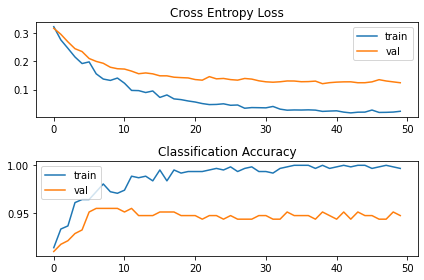

In [12]:
num_epochs = 50
model_name = 'resnet50'

loss_fn = nn.CrossEntropyLoss()  # already includes the Softmax activation
optimizer_resnet = torch.optim.SGD(resnet.parameters(), lr=1e-3)

resnet_train_history, resnet_val_history = train(
    resnet, model_name, num_epochs, train_dataloader, val_dataloader, loss_fn, optimizer_resnet)

plotTrainingHistory(resnet_train_history, resnet_val_history)
